In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import bz2
import corner
import h5py
import pickle
from scipy.interpolate import interp1d, RectBivariateSpline
from scipy.integrate import cumtrapz
import scipy.stats as ss
import seaborn as sns
import sys
import tqdm

sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

In [3]:
d = '/Users/wfarr/Code/pydelfi'
try:
    sys.path.index(d)
except ValueError:
    sys.path.append(d)
    
from true_params import true_params, uncert
import pydelfi.ndes as ndes
from pydelfi import delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
with h5py.File('/Users/hyraland/Projects/GW/Cosmology/PISNLineCosmography/thetas.h5', 'r') as f:
    thetas = array(f['Theta'])
thetas = sort(concatenate((thetas, [0,1])))
ticum = interp1d(linspace(0, 1, len(thetas)), thetas)

with h5py.File('/Users/hyraland/Projects/GW/Cosmology/PISNLineCosmography/optimal_snr.h5', 'r') as f:
    ms = array(f['ms'])
    rhos = array(f['SNR'])
oint = RectBivariateSpline(ms, ms, rhos)

In [5]:
oint.ev(array([1,2,3]), array([2,3,4]))

array([3.39704894, 5.34188423, 7.06473383])

In [14]:
def draw_pl(N, alpha, xmin, xmax):
    u = rand(N)
    
    return (xmin**(1+alpha)*(1-u) + xmax**(1+alpha)*u)**(1.0/(1+alpha))
def draw_z(R0, g, H0, Om, w, zmax):
    zs = expm1(linspace(log(1), log(1+zmax), 1000))
    c = cosmo.wCDM(H0*u.km/u.s/u.Mpc, Om, 1.0-Om, w)
    dNdz = R0*4.0*pi*c.differential_comoving_volume(zs).to(u.Gpc**3/u.sr).value*(1+zs)**(g-1)
    N = trapz(dNdz, zs)
    zcum = cumtrapz(dNdz, zs, initial=0)
    
    icum = interp1d(zcum, zs)
    
    n = random.poisson(N)
    return icum(N*rand(n))
def mc_eta_from_m1m2(m1, m2):
    mt = m1+m2
    eta = m1*m2/(mt*mt)
    mc = mt*eta**(0.6)
    return mc, eta
def m1m2_from_mc_eta(mc, eta):
    mt = mc/eta**(0.6)
    
    disc = 1-4*eta
    sd = sqrt(disc)
    m1 = 0.5*mt*(1+sd)
    m2 = 0.5*mt*(1-sd)
    return m1, m2
def draw(R0, MMin, MMax, alpha, beta, gamma, H0, Om, w):
    zmax = 3 # at z = 3, 50-50 in source frame is SNR ~ 5, so rare.
    ztrue = draw_z(R0, gamma, H0, Om, w, 3)
    ctrue = cosmo.wCDM(H0*u.km/u.s/u.Mpc, Om, 1-Om, w)
    dltrue = ctrue.luminosity_distance(ztrue).to(u.Gpc).value
    m1true = draw_pl(len(ztrue), -alpha, MMin, MMax)
    m2true = draw_pl(len(ztrue), beta, MMin, m1true)
    m1trueobs = m1true*(1+ztrue)
    m2trueobs = m2true*(1+ztrue)
    thetatrue = ticum(rand(len(m1trueobs)))
    
    rhotrue = thetatrue*oint.ev(m1trueobs, m2trueobs)/dltrue
    
    rhoobs = rhotrue + randn(len(rhotrue))
    
    sel = rhoobs > 8
    
    ztrue = ztrue[sel]
    dltrue = dltrue[sel]
    m1true = m1true[sel]
    m2true = m2true[sel]
    m1trueobs = m1trueobs[sel]
    m2trueobs = m2trueobs[sel]
    rhotrue = rhotrue[sel]
    thetatrue = thetatrue[sel]
    rhoobs = rhoobs[sel]
    
    mctrueobs, etatrue = mc_eta_from_m1m2(m1trueobs, m2trueobs)
    
    smc = abs(uncert['threshold_snr']/rhoobs*0.05)
    mcobs = random.lognormal(mean=log(mctrueobs), sigma=smc)
    
    se = abs(uncert['threshold_snr']/rhoobs*uncert['eta'])
    etobs = etatrue + se*randn(len(se))
    while np.any(etobs > 0.25) or np.any(etobs < 0):
        s = (etobs > 0.25) | (etobs < 0)
        etobs[s] = etatrue[s] + se[s]*randn(len(se[s]))
    
    m1obs, m2obs = m1m2_from_mc_eta(mcobs, etobs)

    st = abs(uncert['threshold_snr']/rhoobs*uncert['Theta'])
    thetaobs = thetatrue + st*randn(len(st))
    while np.any(thetaobs < 0) or np.any(thetaobs > 1):
        s = (thetaobs < 0) | (thetaobs > 1)
        thetaobs[s] = thetatrue[s] + st[s]*randn(len(st[s]))
    
    dlobs = thetaobs*oint.ev(m1obs, m2obs)/rhoobs
    
    return m1obs, m2obs, dlobs, thetaobs

Number after 1 year = 1172


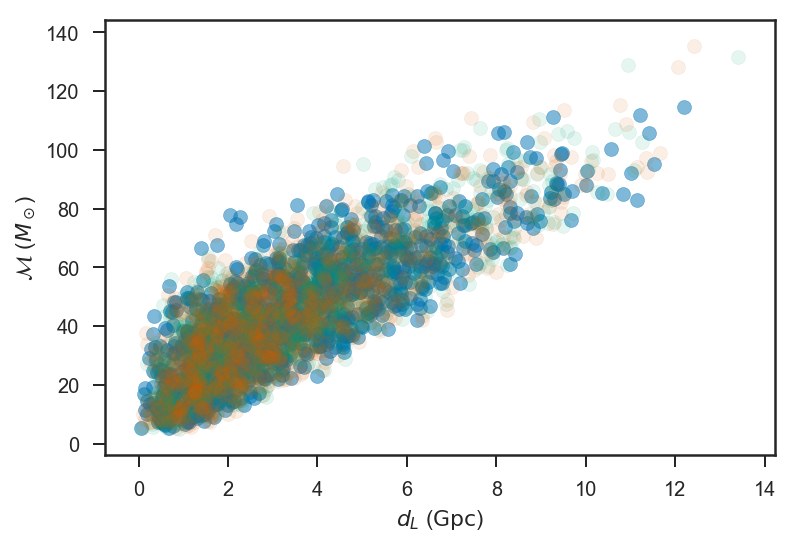

In [15]:
m1, m2, dl, t = draw(0.5*100, 5.0, 50.0, 0.75, 0.0, 3.0, 70.0, 0.3, -1)
print('Number after 1 year = {:d}'.format(len(m1)))
scatter(dl, mc_eta_from_m1m2(m1, m2)[0], alpha=0.5)
ylabel(r'$\mathcal{M}$ ($M_\odot$)')
xlabel(r'$d_L$ ($\mathrm{Gpc}$)')
m1, m2, dl, t = draw(0.5*100, 5.0, 50.0, 0.75, 0.0, 3.0, 70.0, 0.3, -1.1)
scatter(dl, mc_eta_from_m1m2(m1, m2)[0], alpha=0.1)
m1, m2, dl, t = draw(0.5*100, 5.0, 50.0, 0.75, 0.0, 3.0, 70.0, 0.3, -0.9)
scatter(dl, mc_eta_from_m1m2(m1,m2)[0], alpha=0.1)

In [16]:
def mc_dl_to_summary(mc, dl):
    bins = sort(concatenate((percentile(dl, [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]), [0.0, 1.01*np.max(dl)])))
    cent = 0.5*(bins[1:]+bins[:-1])
    
    ds = []
    mm = []
    for l, h in zip(bins[:-1], bins[1:]):
        s = (l <= dl) & (dl < h)
        ds.append(median(dl[s]))
        mm.append(np.max(mc[s]))
    
    return len(m1), array(ds), array(mm) #why m1?

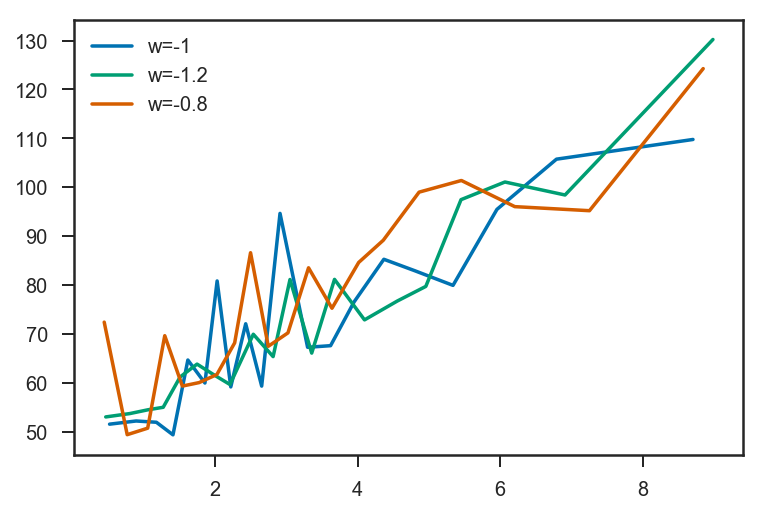

In [17]:
m1, m2, dl, t = draw(0.5*100, 5.0, 50.0, 0.75, 0.0, 3.0, 70.0, 0.3, -1)
_, c, m = mc_dl_to_summary(mc_eta_from_m1m2(m1, m2)[0], dl)
l, = plot(c, m, label='w=-1')

m1, m2, dl, t = draw(0.5*100, 5.0, 50.0, 0.75, 0.0, 3.0, 70.0, 0.3, -1.2)
_, c, m = mc_dl_to_summary(mc_eta_from_m1m2(m1,m2)[0], dl)
l, = plot(c, m, label='w=-1.2')

m1, m2, dl, t = draw(0.5*100, 5.0, 50.0, 0.75, 0.0, 3.0, 70.0, 0.3, -0.8)
n, c, m = mc_dl_to_summary(mc_eta_from_m1m2(m1,m2)[0], dl)
l, = plot(c, m, label='w=-0.8')

legend(loc='best')

We want to impose cosmological constraints, so we imagine a 1% measurement of H0 and Omh2, and transform back to H0 and Om.

In [18]:
Om = 0.3
H0 = 70
h0 = 0.7

Covhomh2 = diag([(0.01*H0)**2, (0.01*Om*h0**2)**2])
J = array([[1.0, 0.0], [2.0*Om*h0/100.0, h0**2]])# d(H0, Omh2)/d(H0, Om)
Jinv = np.linalg.inv(J)
Covhom = np.dot(Jinv.T, np.dot(Covhomh2, Jinv))

In [19]:
# Parameter order is R0*T, MMin, MMax, alpha, beta, gamma, H0, Om, w
prior_mean = array([0.5*100, 5.0, 50.0, 0.75, 0.0, 3.0, 70.0, 0.3, -1.0])
prior_cov = np.diag([(0.2*0.5*100)**2, 1.0**2, 10.0**2, 0.5**2, 1.0**2, 1.0**2, 0.7**2, 0.**2, 0.5**2])
prior_cov[-3:-1, -3:-1] = Covhom
lower = array([0.0, 3.0, 35.0, 0.0, -2.0, 0.0, 55.0, 0.05, -2.0])
upper = array([0.5*200, 10.0, 75.0, 2.0, 2.0, 6.0, 95.0, 0.75, 0.0])
prior = priors.TruncatedGaussian(prior_mean, prior_cov, lower, upper)

In [20]:
theta_fiducial = prior_mean

def simulator(theta, seed, simulator_args, batch):
    rst = random.get_state()  ## explanation: https://blog.csdn.net/mr_muli/article/details/80913915
    random.seed(seed)
    try:
        m1, m2, dl, t = draw(*theta)
        mc = mc_eta_from_m1m2(m1, m2)[0]
        n, c, m = mc_dl_to_summary(mc, dl)
    finally:
        random.set_state(rst)
    
    return concatenate(([n], c, m))

nd = len(simulator(theta_fiducial, None, None, 1))

compressor = score.Gaussian(nd, theta_fiducial, prior_mean=prior_mean, prior_covariance=prior_cov)

In [21]:
compressor.compute_mean_covariance(simulator, 512)

In [22]:
compressor.compute_derivatives(simulator, 8, 0.1*sqrt(diag(prior_cov)))

In [23]:
compressor.compute_fisher()

In [24]:
def compress(d, compres_args):
    return compressor.scoreMLE(d)

In [25]:
with bz2.BZ2File('LFI/compressor.pkl.bz2', 'w') as f:
    pickle.dump(compressor, f)

Execute the below to re-load the compressor:

In [26]:
with bz2.BZ2File('LFI/compressor.pkl.bz2', 'r') as f:
    compressor = pickle.load(f)

In [27]:
d0 = simulator(prior_mean, None, None, 1)
t0 = compress(d0, None)
t0

array([ 4.91789106e+01,  4.99906645e+00,  5.02536433e+01,  7.70423100e-01,
        3.37710361e-02,  2.93366334e+00,  7.00285679e+01,  3.00281232e-01,
       -1.01551170e+00])

In [28]:
NDEs = [ndes.MixtureDensityNetwork(n_parameters=9, n_data=9, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=0),
       ndes.MixtureDensityNetwork(n_parameters=9, n_data=9, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
       ndes.MixtureDensityNetwork(n_parameters=9, n_data=9, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
       ndes.MixtureDensityNetwork(n_parameters=9, n_data=9, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
       ndes.MixtureDensityNetwork(n_parameters=9, n_data=9, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
       ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=9, n_data=9, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=5)]

DelfiEnsemble = delfi.Delfi(t0, prior, NDEs, Finv=compressor.Finv, theta_fiducial=prior_mean, 
                       param_limits = [lower, upper],
                       param_names = [r'R_0 T', r'M_\mathrm{min}', r'M_\mathrm{max}', r'\alpha', r'\beta', r'\gamma', r'H_0', r'\Omega_M', r'w'],
                       results_dir = "./LFI/",
                       input_normalization="fisher")


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.




Sampling approximate posterior...
Done.


/Users/hyraland/anaconda/lib/python3.6/site-packages/scipy/fftpack/basic.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


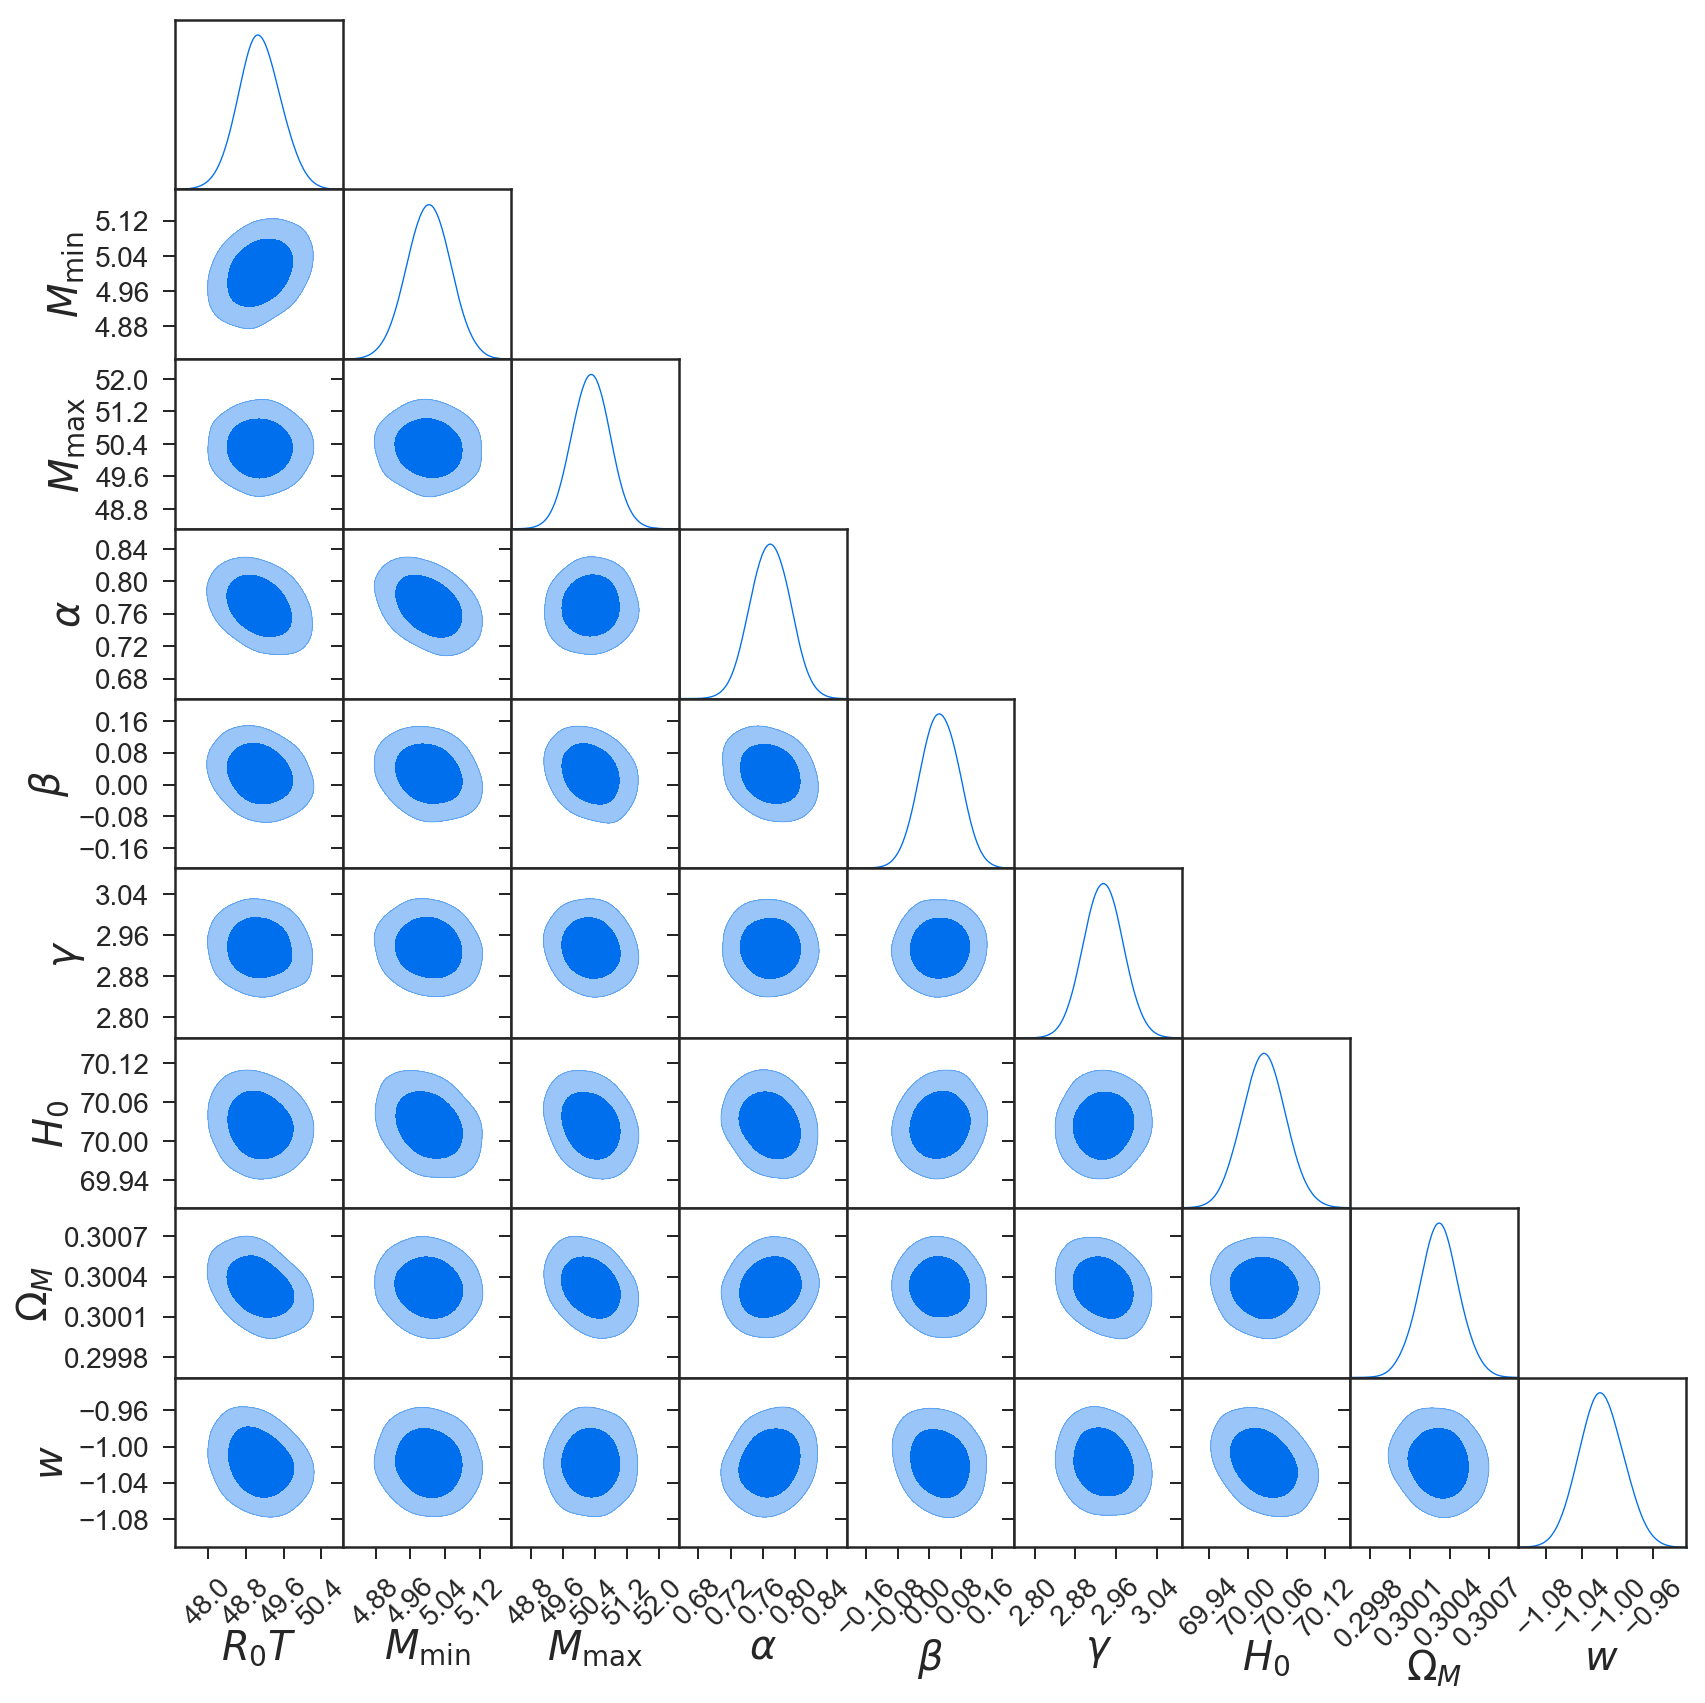

In [29]:
DelfiEnsemble.fisher_pretraining()


Sampling approximate posterior...
Done.


/Users/hyraland/anaconda/lib/python3.6/site-packages/scipy/fftpack/basic.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


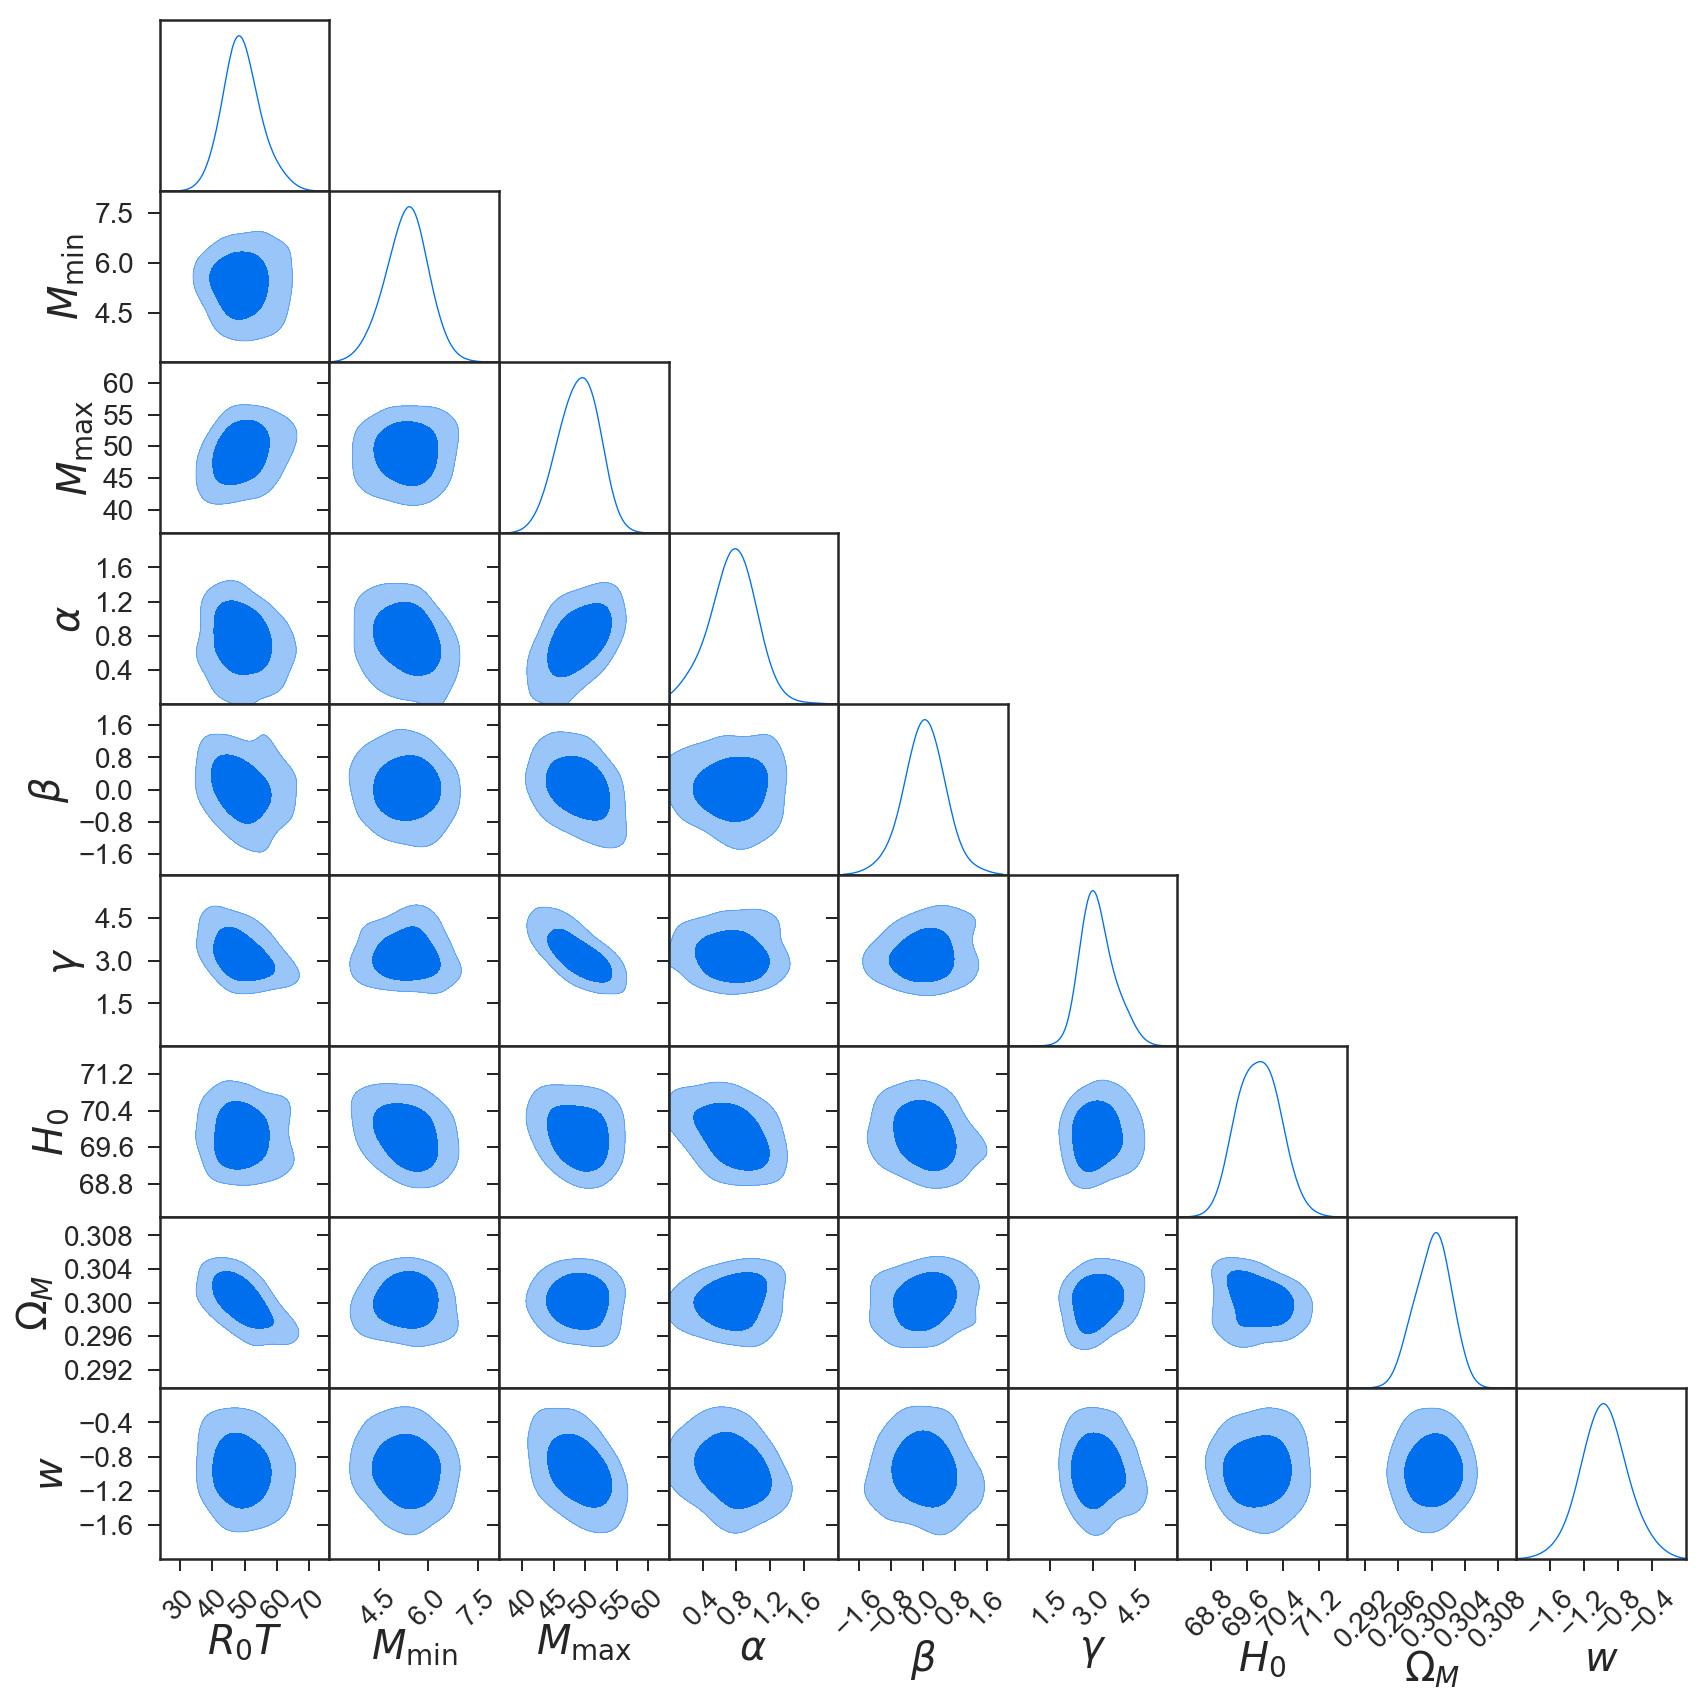

Population 1/5
Sampling proposal density...
Done.



Sampling approximate posterior...
37/|/ 12%|| 37/300 [00:37<02:04,  2.12it/s, train loss=11.8, val loss=13.7, refresh=1]Done.


/Users/hyraland/anaconda/lib/python3.6/site-packages/scipy/fftpack/basic.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


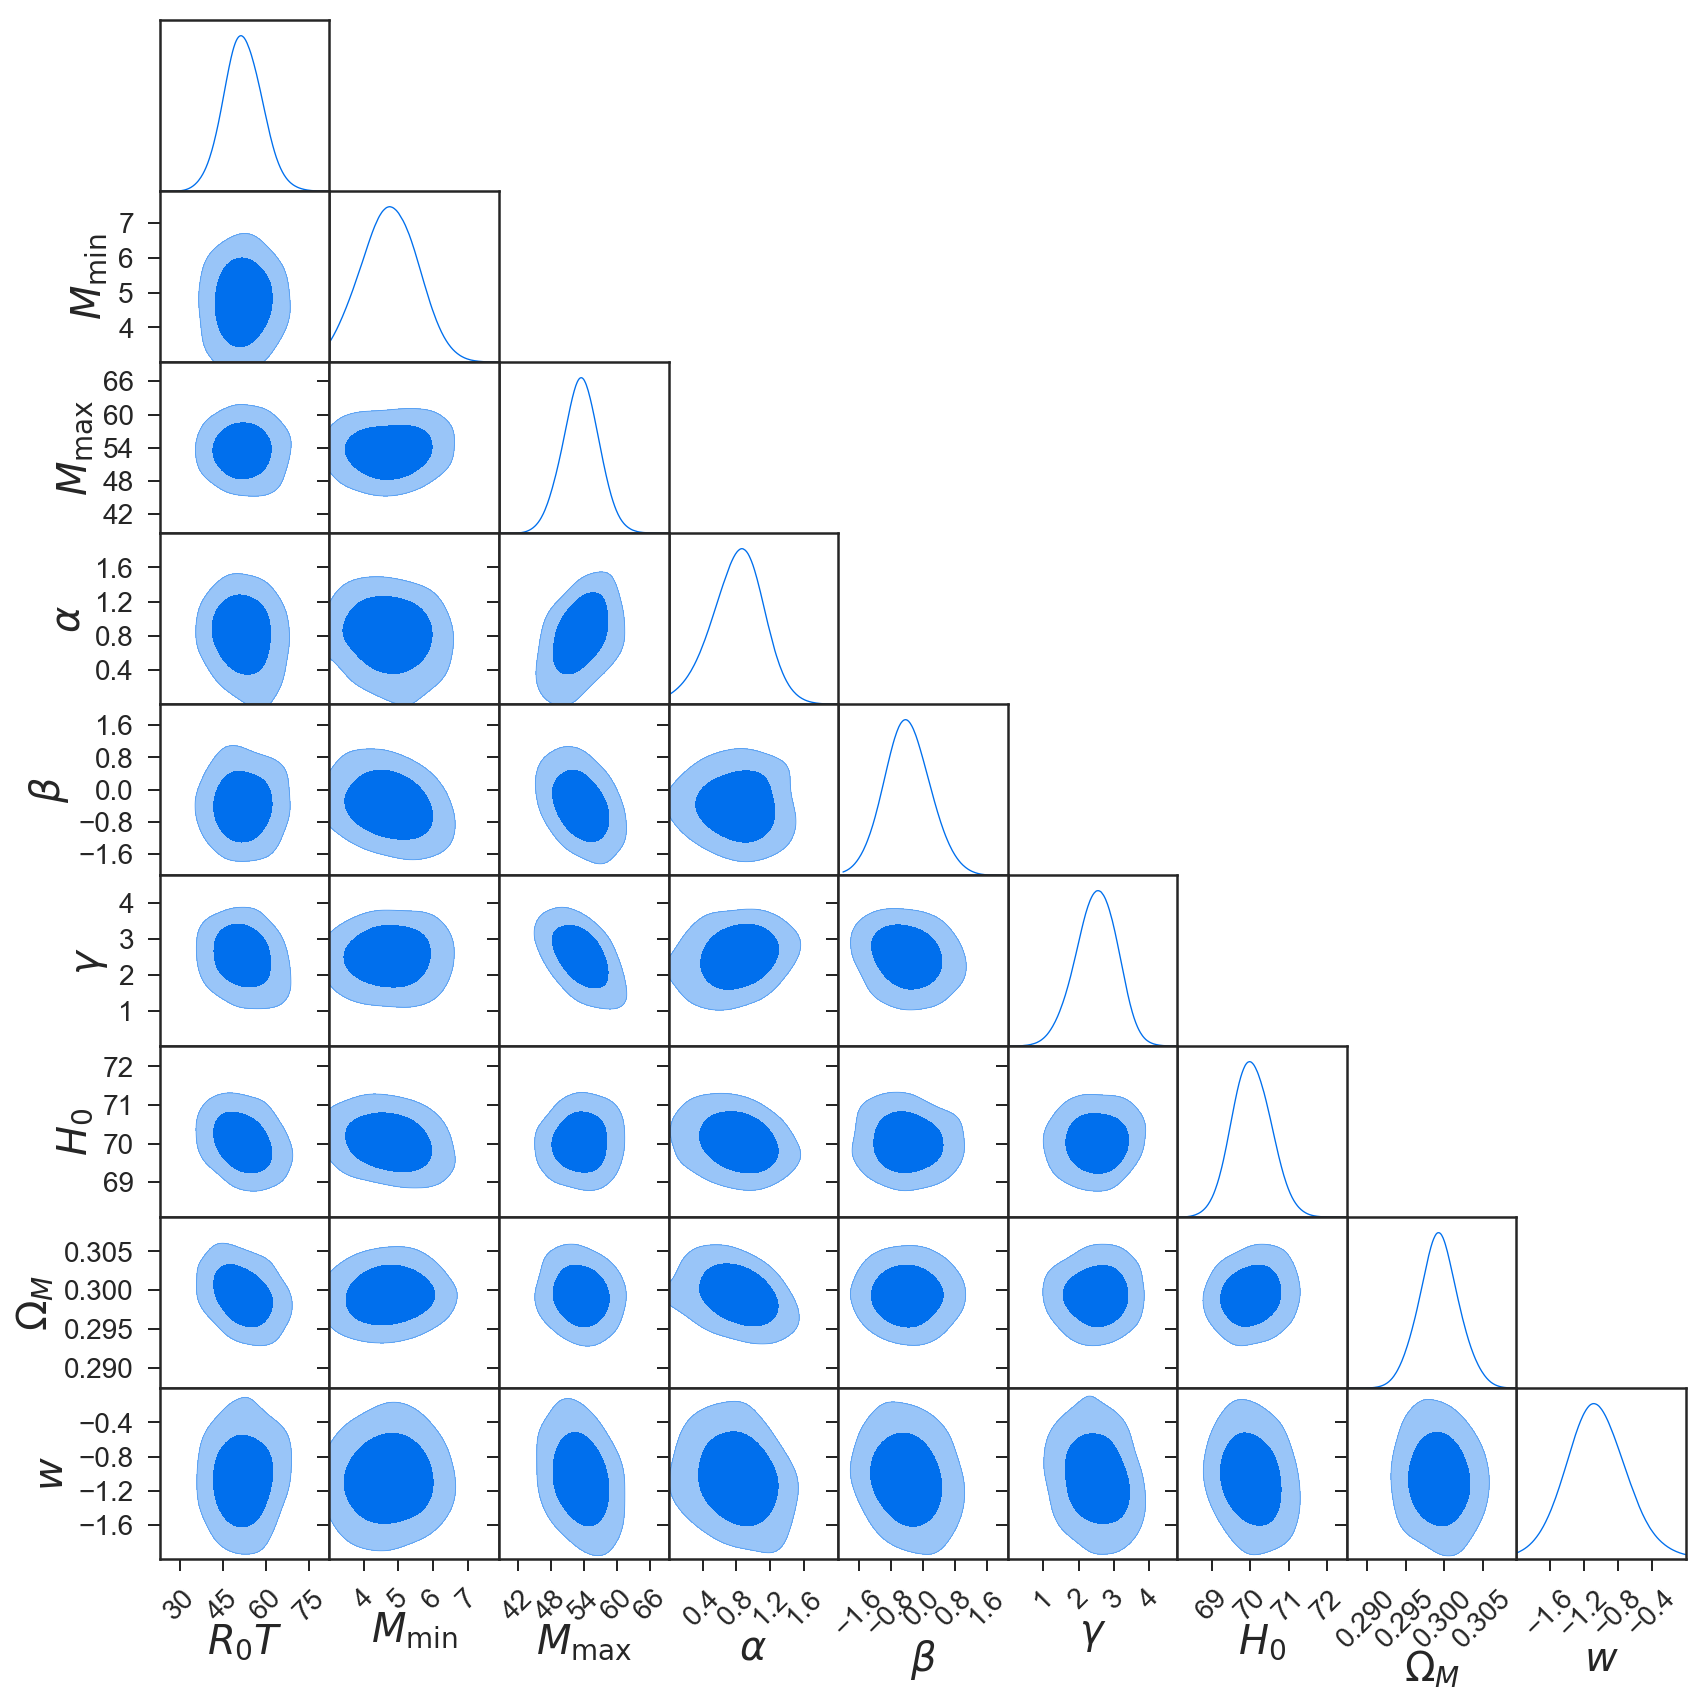

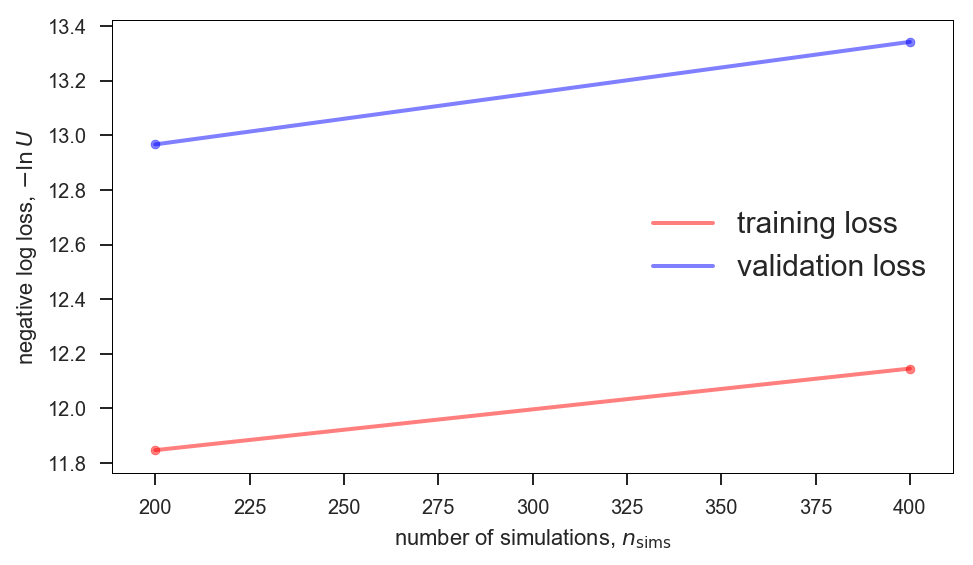

Population 2/5
Sampling proposal density...
Done.



Sampling approximate posterior...
35/|/ 12%|| 35/300 [00:34<01:38,  2.69it/s, train loss=11.7, val loss=13, refresh=1]Done.


/Users/hyraland/anaconda/lib/python3.6/site-packages/scipy/fftpack/basic.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


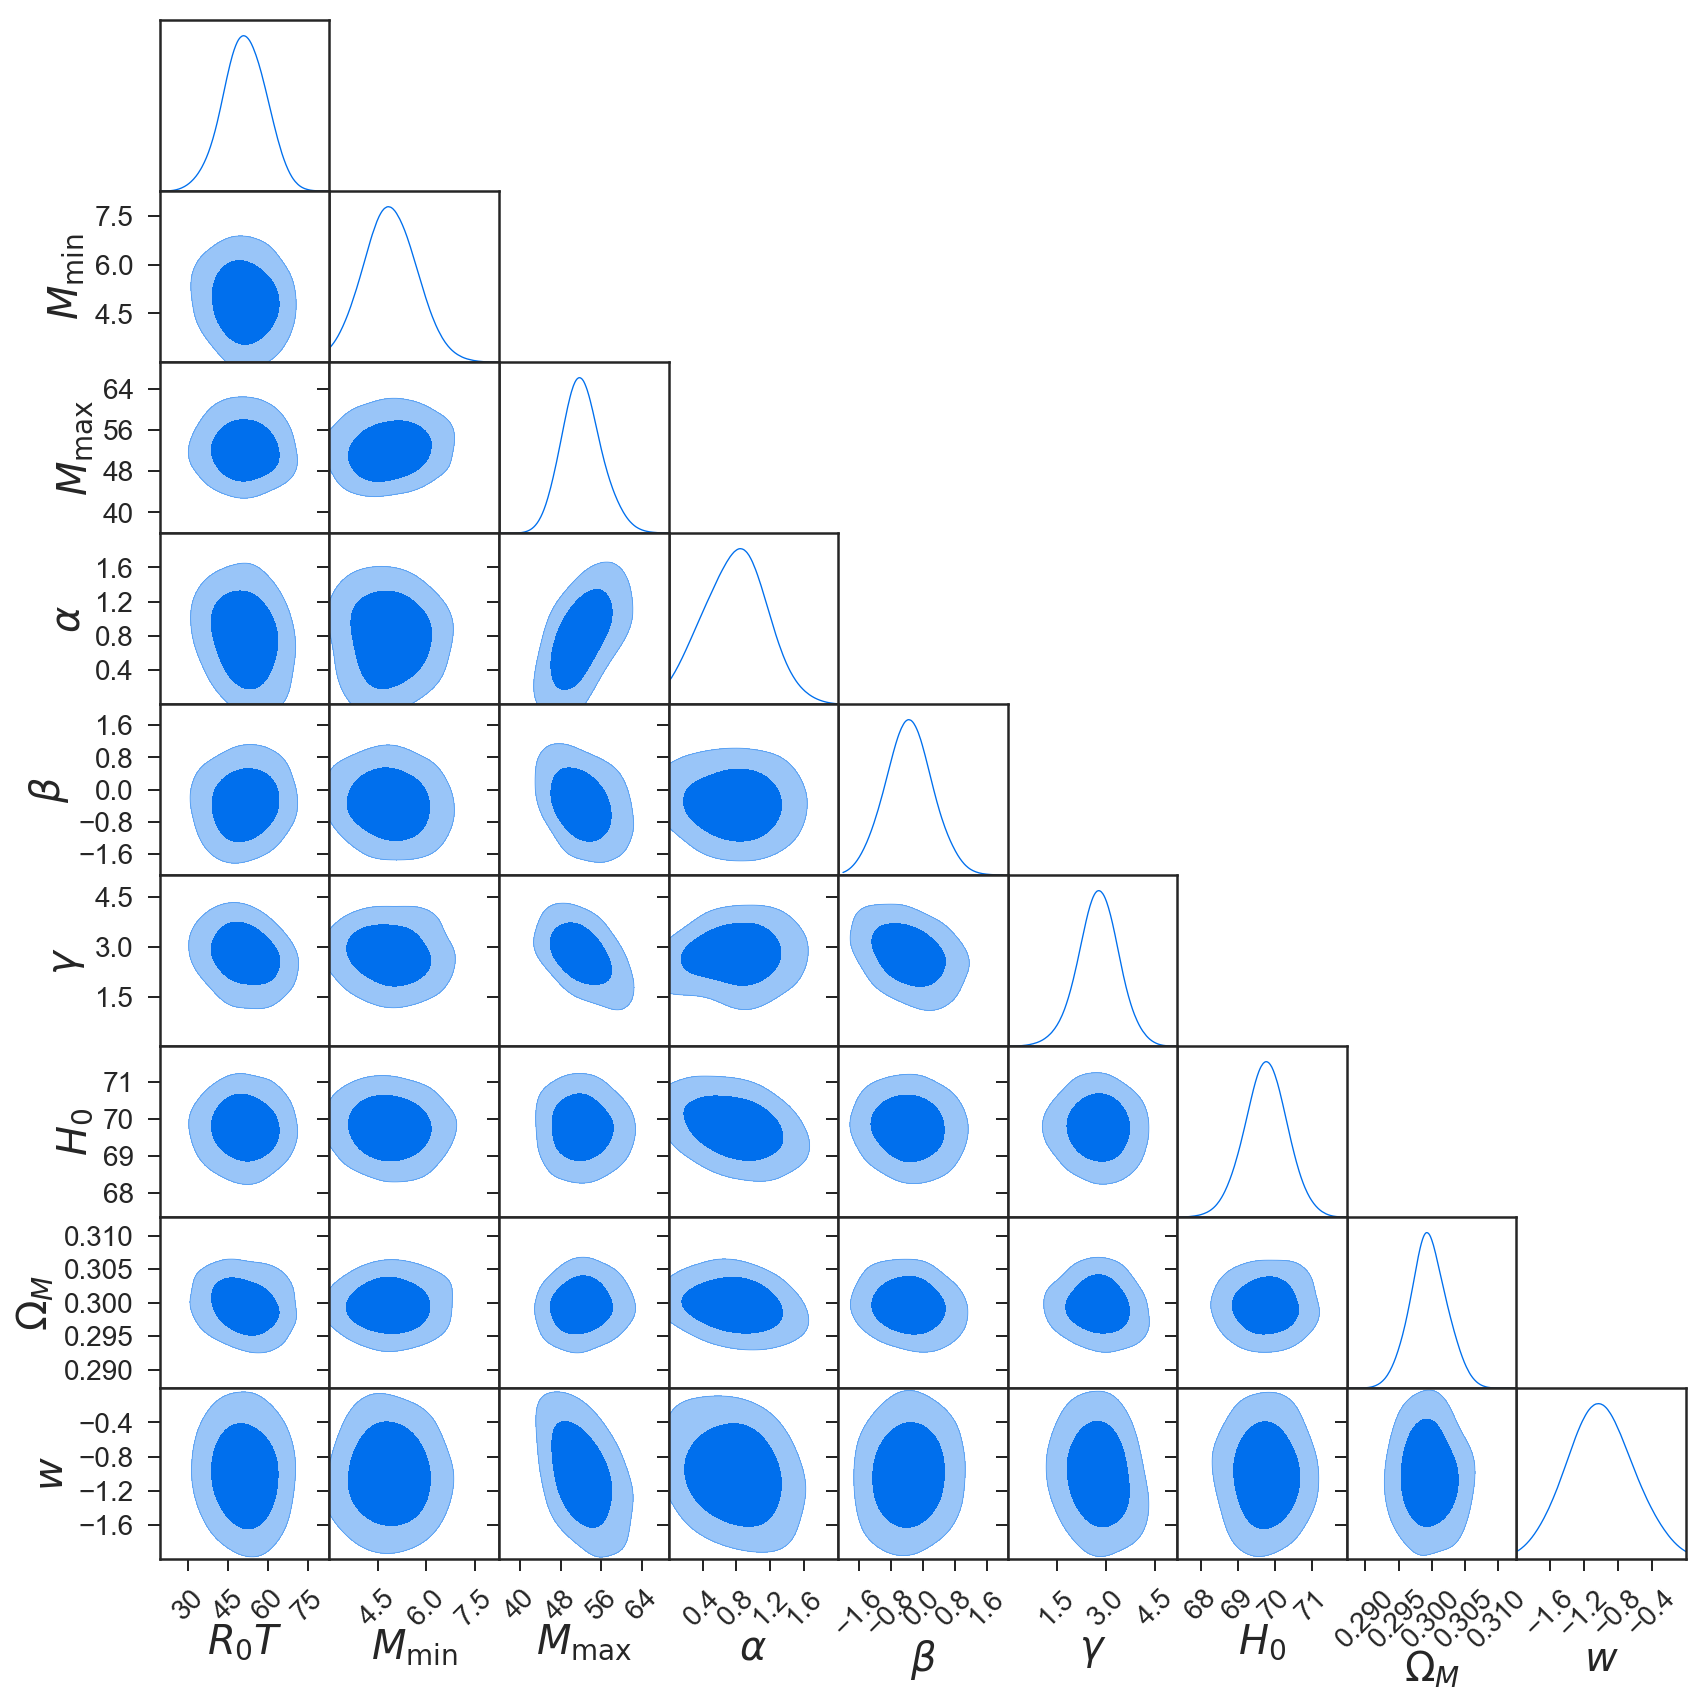

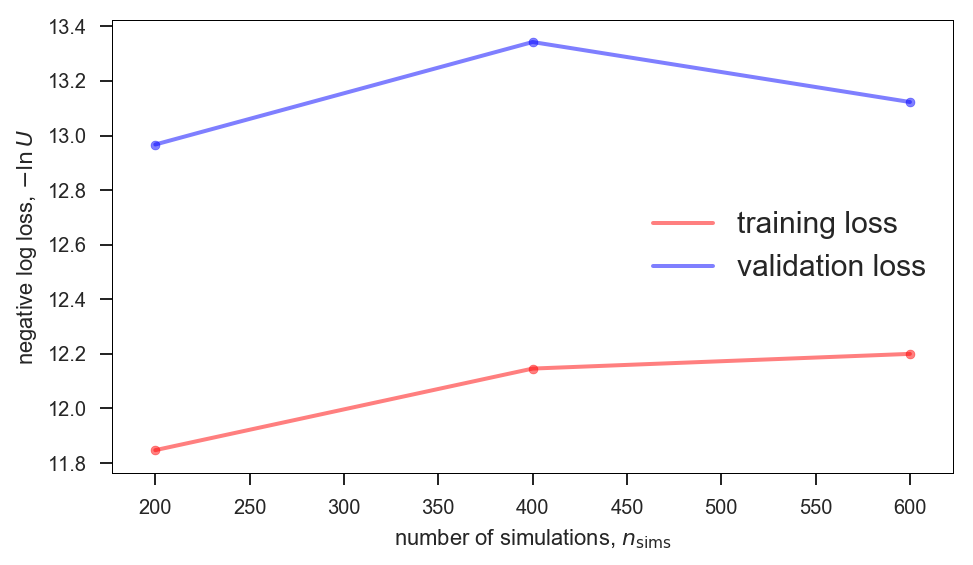

Population 3/5
Sampling proposal density...
Done.



Sampling approximate posterior...
19/|/  6%|| 19/300 [00:24<04:38,  1.01it/s, train loss=11.8, val loss=14, refresh=1]Done.


/Users/hyraland/anaconda/lib/python3.6/site-packages/scipy/fftpack/basic.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


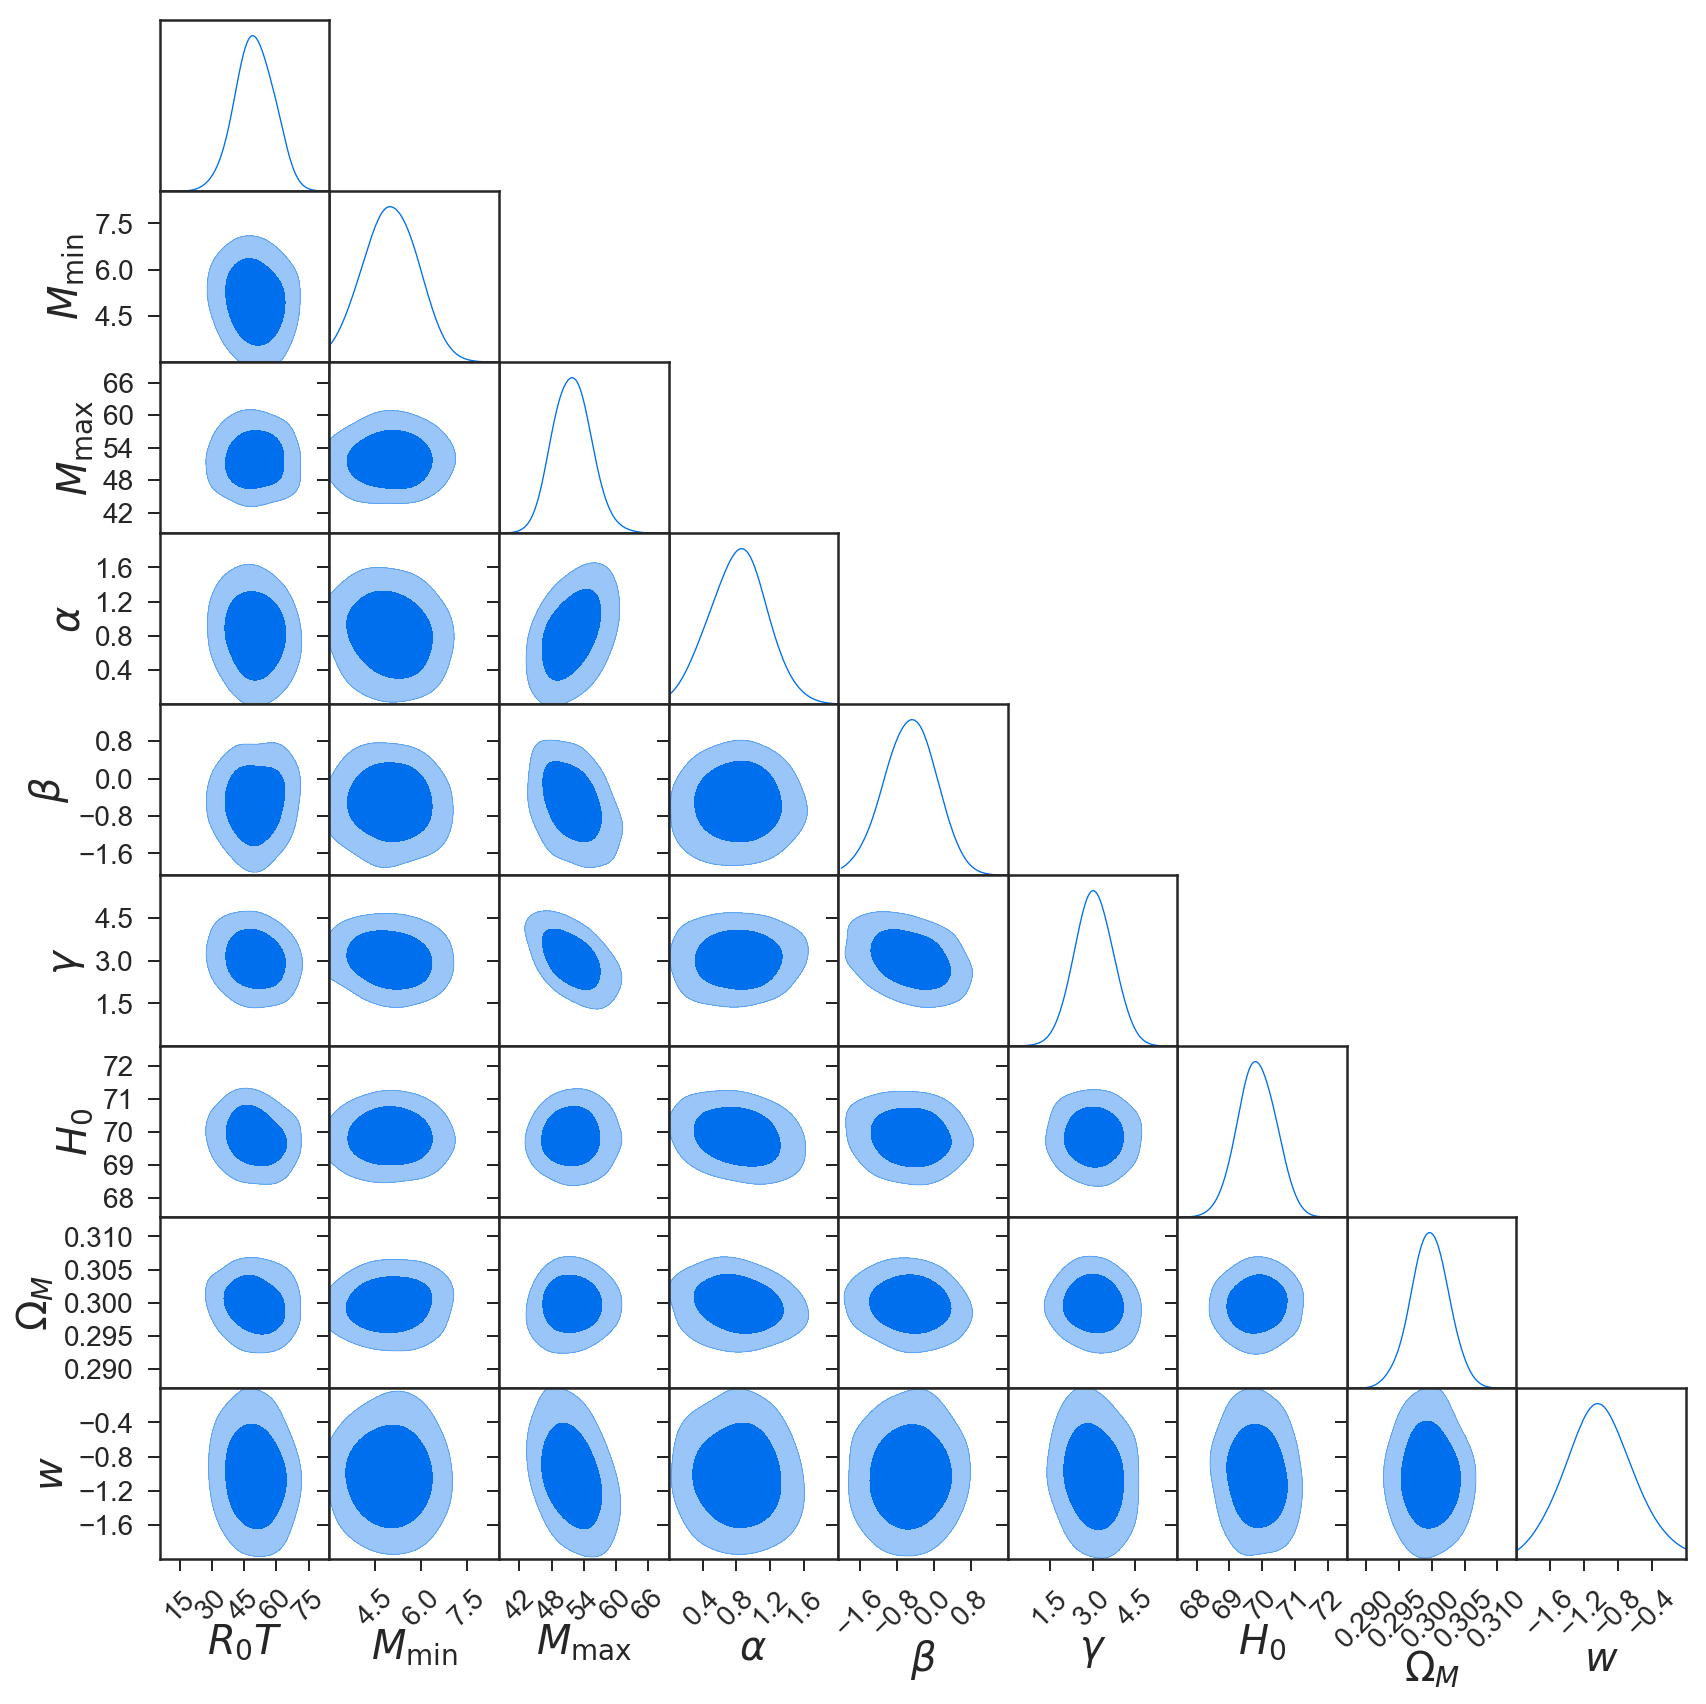

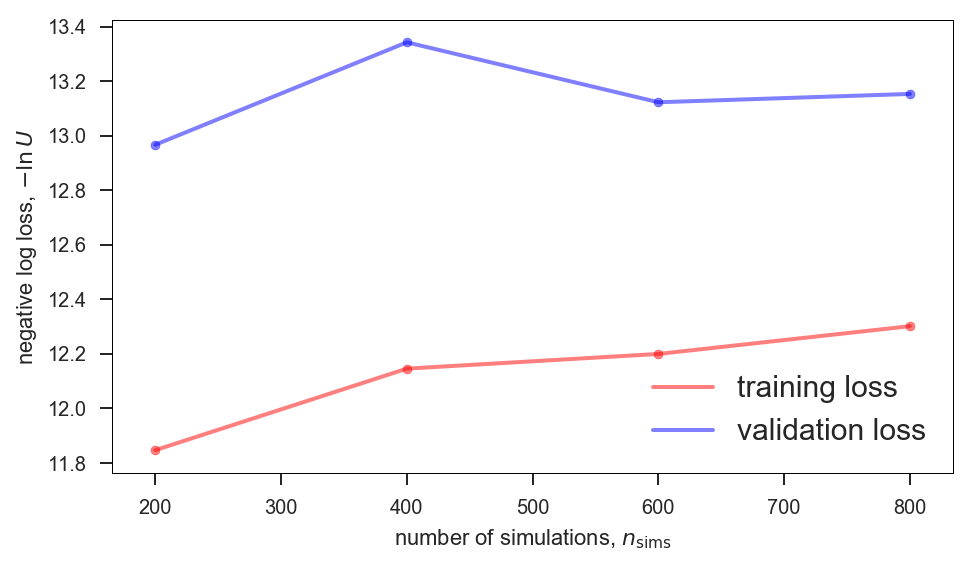

Population 4/5
Sampling proposal density...
Done.


23/|/  8%|| 23/300 [00:21<01:31,  3.02it/s, train loss=12.7, val loss=12.9, refresh=1]



Sampling approximate posterior...
17/|/  6%|| 17/300 [00:36<03:24,  1.38it/s, train loss=12.3, val loss=13.4, refresh=1]Done.


/Users/hyraland/anaconda/lib/python3.6/site-packages/scipy/fftpack/basic.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


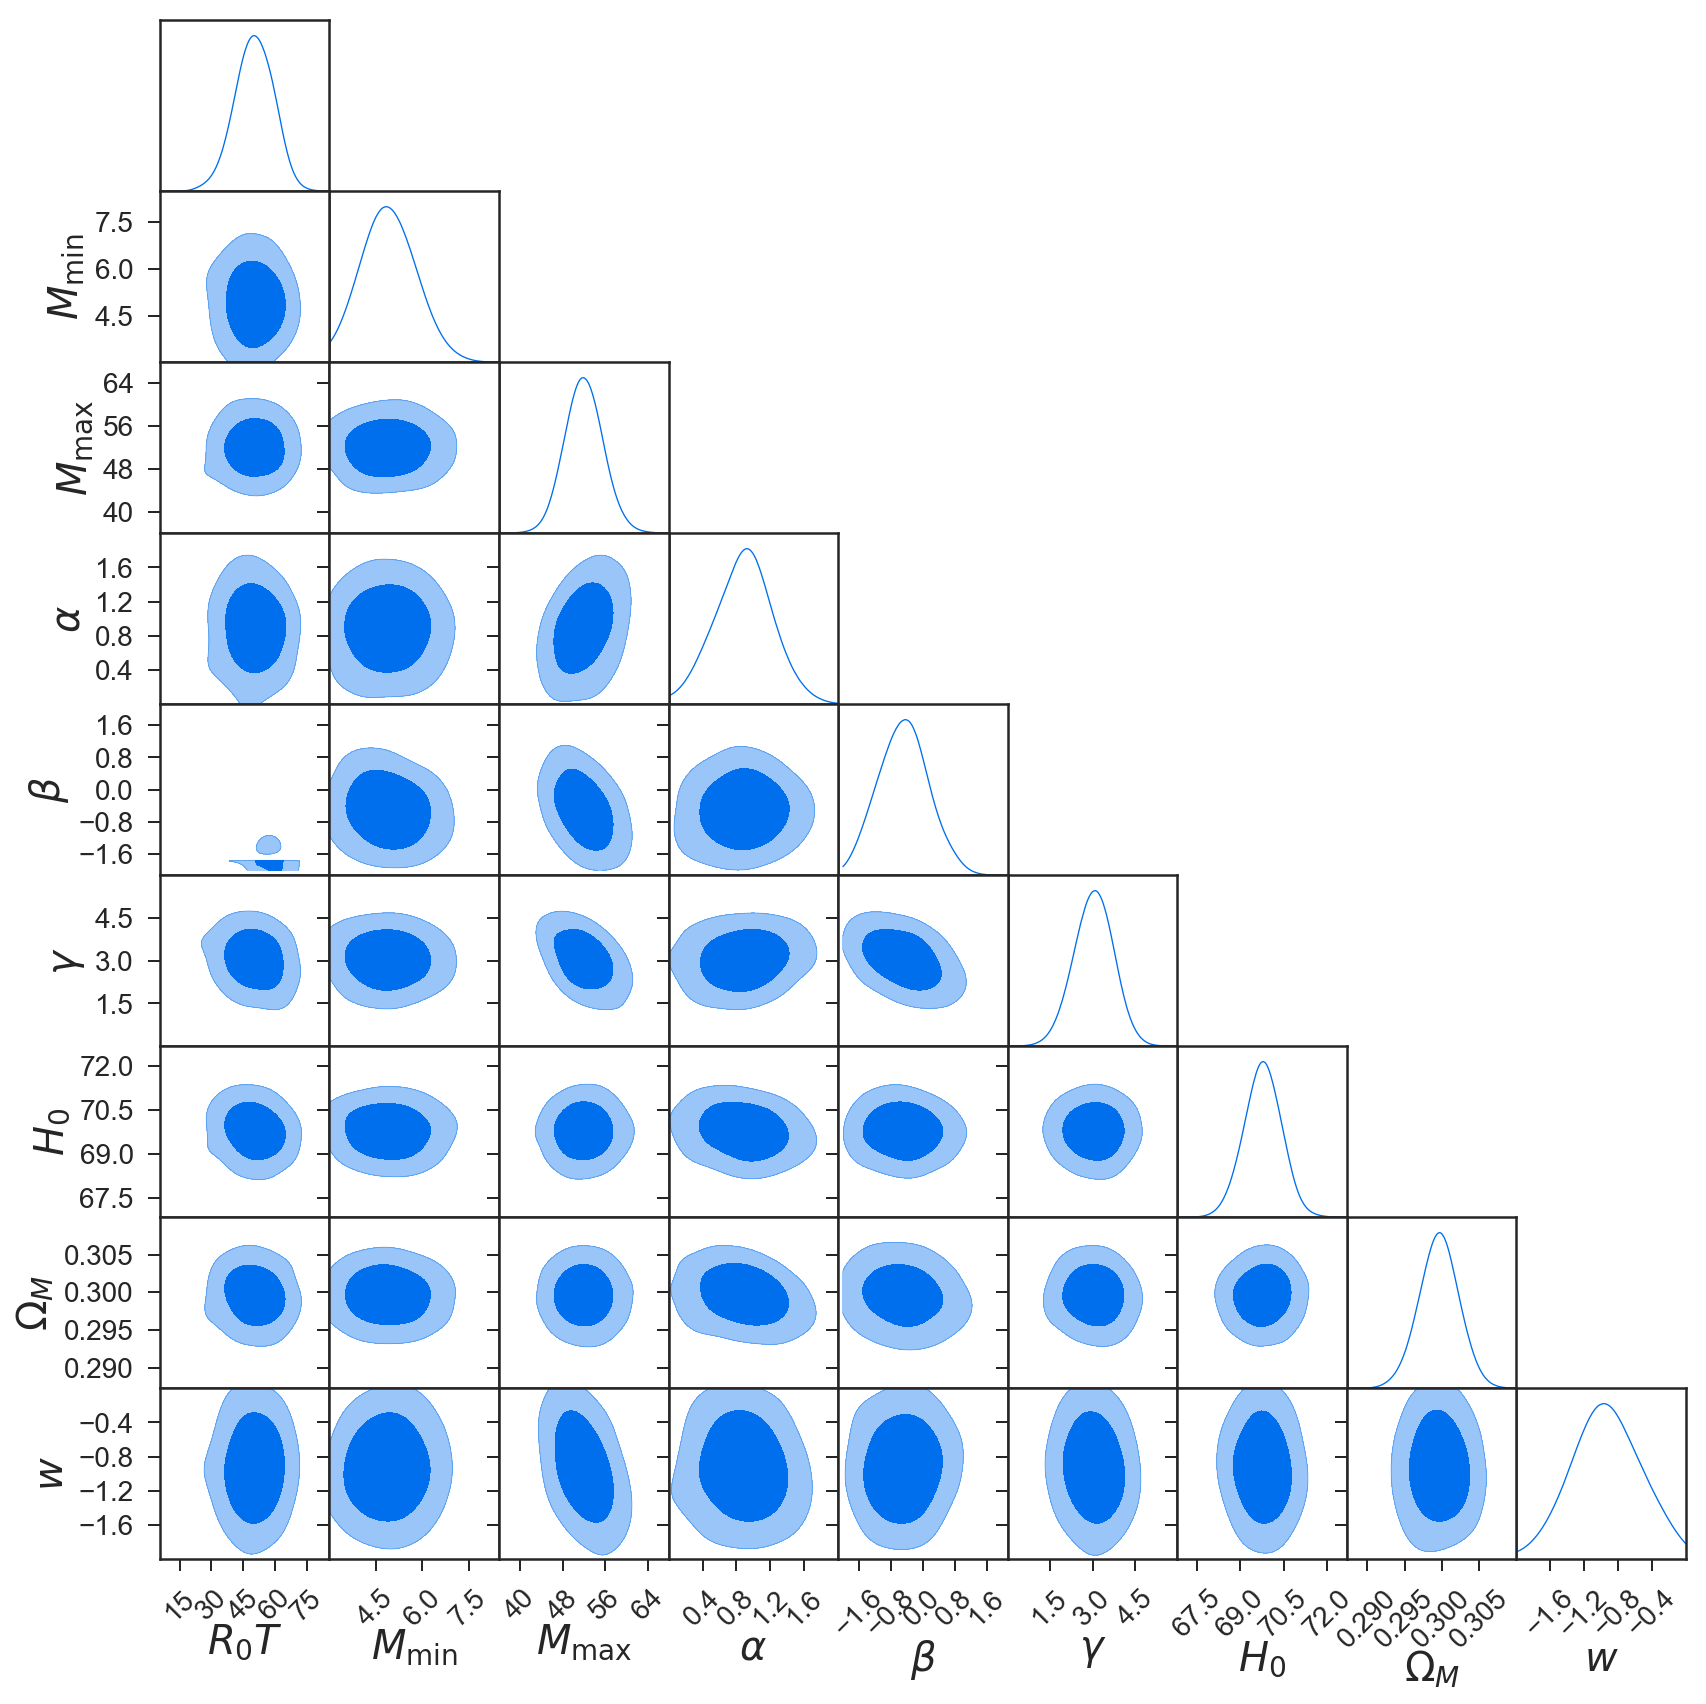

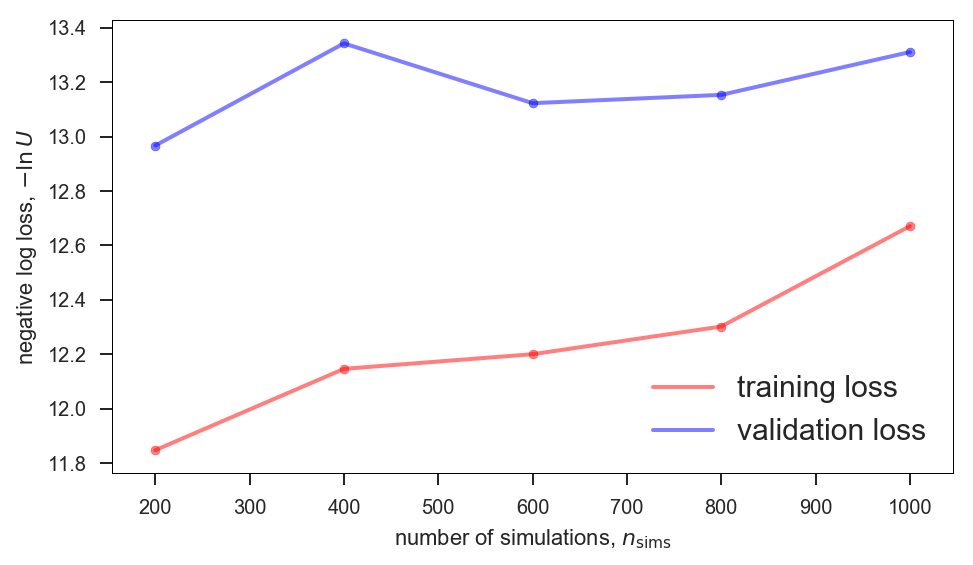

Population 5/5
Sampling proposal density...
Done.


16/|/  5%|| 16/300 [00:20<02:18,  2.05it/s, train loss=12.9, val loss=13.3, refresh=1]
Sampling approximate posterior...
17/|/  6%|| 17/300 [00:29<03:37,  1.30it/s, train loss=12.3, val loss=13.5, refresh=1]Done.


/Users/hyraland/anaconda/lib/python3.6/site-packages/scipy/fftpack/basic.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


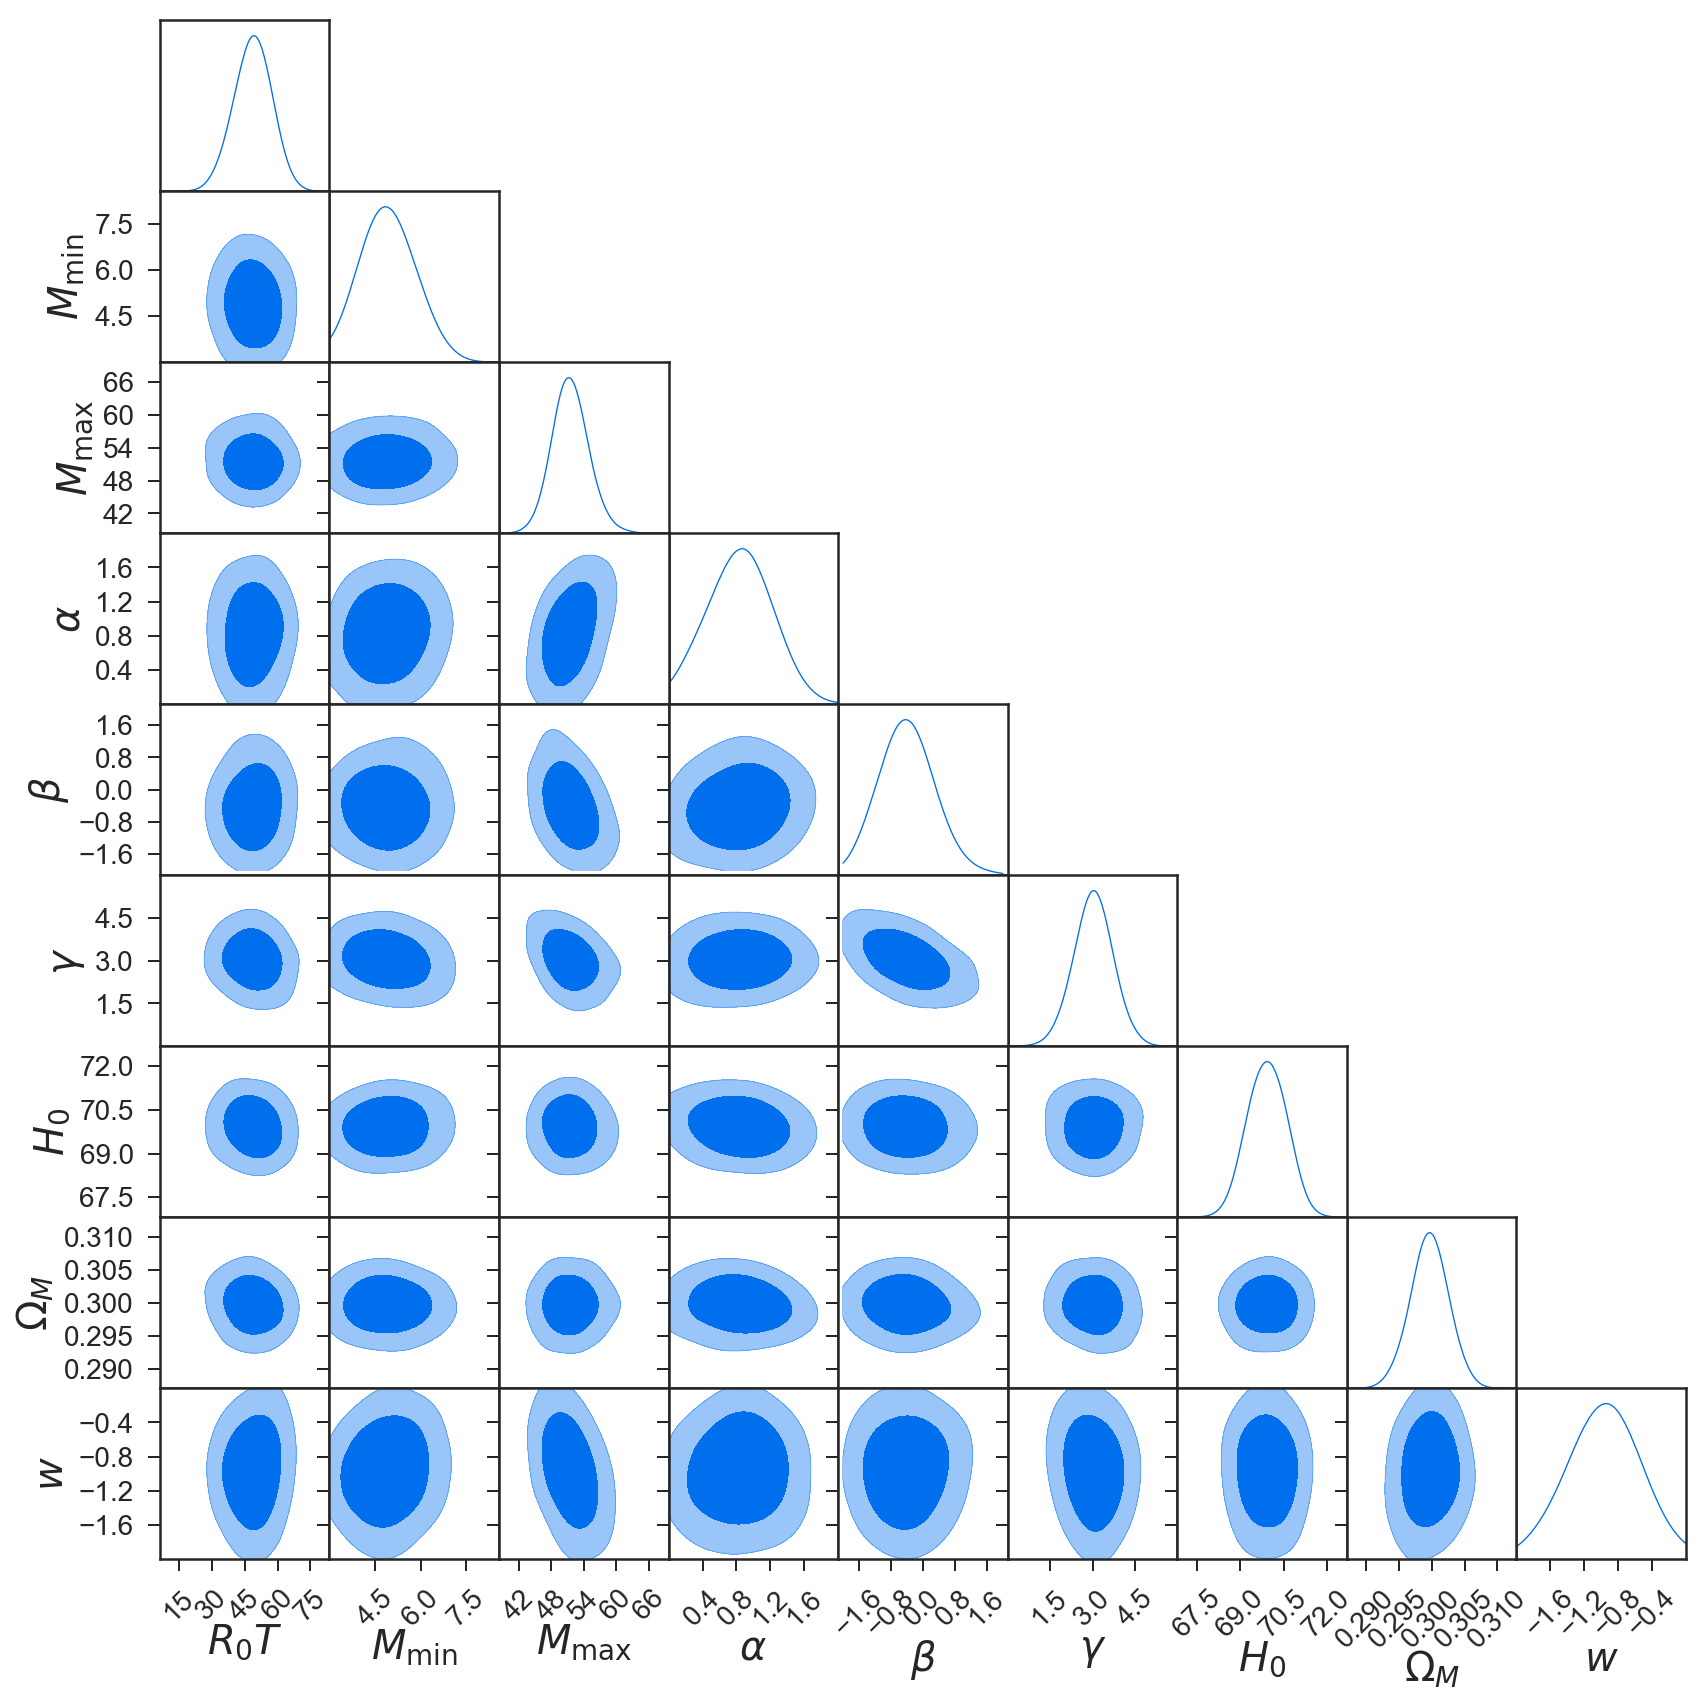

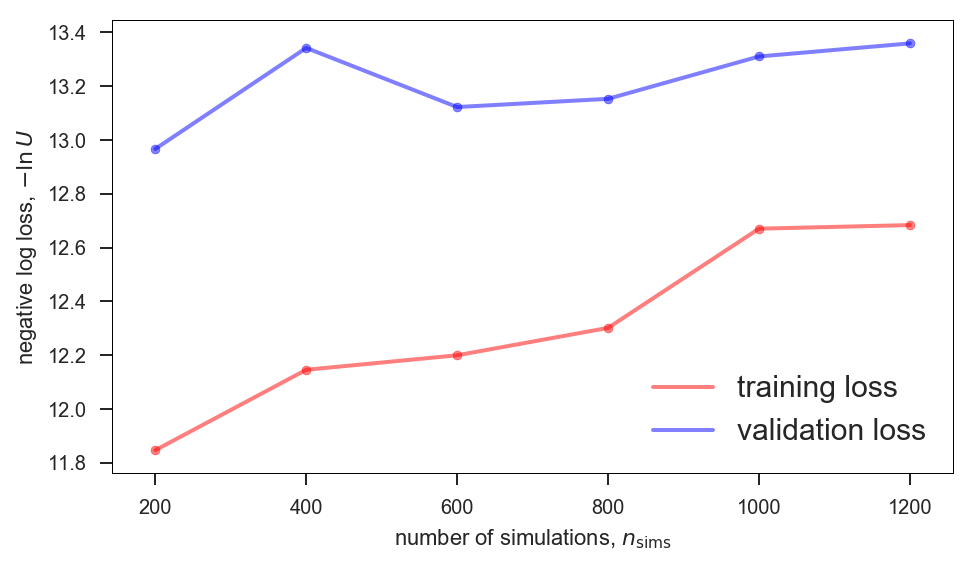

In [30]:
# Initial samples, batch size for population samples, number of populations
n_initial = 200
n_batch = 200
n_populations = 5

# Do the SNL training
DelfiEnsemble.sequential_training(simulator, compress, n_initial, n_batch, n_populations, patience=10,
                       save_intermediate_posteriors=True)

In [31]:
def rewt(samps):
    h0 = samps[:,-3]
    Om = samps[:,-2]
    w = samps[:,-1]
    
    h0wt = ss.norm(70, 0.7).pdf(h0)
    Omwt = ss.norm(0.3*(70/100.0)**2, 0.01*0.3*(70/100.0)**2).pdf(Om*(h0/100.0)**2)*(h0/100.0)**2
    
    wt = h0wt*Omwt
    
    max_wt = np.max(wt)
    
    rs = random.uniform(max_wt, size=len(wt))
    s = rs < wt
    
    return s